Train a w2v model on the vocabulary of the train dataset.
For the cases of unknown words in the test set the average w2v sould initate a vector of 0s.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets contractions

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
import datasets
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Load the dataset from HugginFace and save the train and test parts in .csv files

In [ ]:
# Specify the dataset name and version
dataset_name = "cnn_dailymail"
dataset_version = "3.0.0"

# Load a specific version of the dataset from Hugging Face
dataset = datasets.load_dataset(dataset_name, dataset_version)

# Convert the dataset to a Pandas DataFrame
df_train = pd.DataFrame(dataset['train'])  # You can use 'train', 'test', or 'validation'
df_train.to_csv('train.csv')
df_val = pd.DataFrame(dataset['validation'])  # You can use 'train', 'test', or 'validation'
df_val.to_csv('validation.csv')
#df =pd.read_csv('/content/output_file.csv')

In [ ]:
df_train =pd.read_csv('/content/train.csv')


#Preprocessing
Remove:
- start and end patterns
- parenthesis (and everything insinde them)
- expand contractions (won't =will not)
- stopwords
- 's (sister's =sister)
- sentence tokenization
- lowercasing
- word tokenisation
- remove punctuation
- non- ascii characters (e.g $ 20 million= 20 million)
- lemmatization  

**What was not removed and maybe it should be removed is the numbers!!**

In [ ]:
lemmatizer = WordNetLemmatizer()
def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

def apply_stemming(tokens):
  porter = PorterStemmer()
  return [porter.stem(word) for word in tokens]

def clean_text(x):
  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#',
              '*', '+', '\\', '•', '~', '@', '£',
              '·', '_', '{', '}', '©', '^', '®', '`','--', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â',
              '█', '½', 'à', '…',
              '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―',
              '¥', '▓', '—', '‹', '─',
              '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸',
              '¾', 'Ã', '⋅', '‘', '∞',
              '∙', '）', '↓', '、', '│', '（', '»','«', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
              '¹', '≤', '‡', '√', ]

  x = str(x)
  for punct in puncts:
    x = x.replace(punct, f' {punct} ')
  return x

def remove_non_ascii(tokens):
    return [word for word in tokens if re.match(r'^[^\x00-\x7F]+$', word) is None]

def clean_and_tokenize(article):
    # Remove text within parentheses and everything in it
    cleaned_article = re.sub(r'\([^)]*\)', '', article)

    # Split the text using '-- ' as the delimiter
    parts = re.split(r'-- ', cleaned_article, maxsplit=1)

    # Check if there was a match and reconstruct the text
    cleaned_article = parts[1] if len(parts) > 1 else cleaned_article

    # Remove 'E-mail to a friend' and anything that follows it
    cleaned_article = re.sub(r'E-mail to a friend.*', '', cleaned_article)

    # Expand word contractions
    expanded_article = contractions.fix(cleaned_article)
    # Add a period after the closing quotation mark if there is a space and a capital letter
    text_with_period = re.sub(r'(")([ ])([A-Z])', r'\1.\2\3', expanded_article)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text_with_period)
    filtered_article = [word for word in word_tokens if word.lower() not in stop_words and word.lower() != "'s"]
    filtered_article = ' '.join(filtered_article)

    sentences = sent_tokenize(filtered_article)
    # Lowercase the text
    sentences = [sentence.lower() for sentence in sentences]
    # Tokenize sentences
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    # Remove punctuation using custom clean_text function
    tokenized_sentences_no_punct = [
        [word for word in word_tokenize(clean_text(sentence)) if word not in string.punctuation]
        for sentence in sentences]
    tokenized_sentences_no_ascii = [
    remove_non_ascii(sentence)
    for sentence in tokenized_sentences_no_punct]
    # Apply lemmatization
    tokenized_sentences_lemmatized = [
        apply_lemmatization(sentence)
        for sentence in tokenized_sentences_no_ascii
        ]

    # Remove empty lists
    tokenized_sentences_lemmatized = [sentence for sentence in tokenized_sentences_lemmatized if sentence]

    return tokenized_sentences_lemmatized




In [ ]:
df_train=df_train.head(30000)

In [ ]:
df_train['cleaned_article'] = df_train['article'].apply(clean_and_tokenize)
df_train.head()

,Unnamed: 0,article,highlights,id,cleaned_article
0,0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,"[[harry, potter, star, daniel, radcliffe, gain..."
1,1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,"[[ninth, floor, miami, dade, pretrial, detenti..."
2,2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,"[[driver, minneapolis, bridge, collapsed, told..."
3,3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,"[[doctor, removed, five, small, polyp, preside..."
4,4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,"[[national, football, league, indefinitely, su..."


In [ ]:
rows_to_display = [0,1,2]  # Replace with the row indices you want to check

for row_index in rows_to_display:
    print(f"Row {row_index}:")
    print(df_train['cleaned_article'].iloc[row_index])
    print("\n---\n")

Row 0:
[['harry', 'potter', 'star', 'daniel', 'radcliffe', 'gain', 'access', 'reported', '20', 'million', 'fortune', 'turn', '18', 'monday', 'insists', 'money', 'cast', 'spell'], ['daniel', 'radcliffe', 'harry', 'potter', 'harry', 'potter', 'order', 'phoenix'], ['disappointment', 'gossip', 'columnist', 'around', 'world', 'young', 'actor', 'say', 'plan', 'fritter', 'cash', 'away', 'fast', 'car', 'drink', 'celebrity', 'party'], ['plan', 'one', 'people', 'soon', 'turn', '18', 'suddenly', 'buy', 'massive', 'sport', 'car', 'collection', 'something', 'similar', 'told', 'australian', 'interviewer', 'earlier', 'month'], ['think', 'particularly', 'extravagant'], ['thing', 'like', 'buying', 'thing', 'cost', '10', 'pound', 'book', 'cd', 'dvd'], ['18', 'radcliffe', 'able', 'gamble', 'casino', 'buy', 'drink', 'pub', 'see', 'horror', 'film', 'hostel', 'part', 'ii', 'currently', 'six', 'place', 'number', 'one', 'movie', 'uk', 'box', 'office', 'chart'], ['detail', 'mark', 'landmark', 'birthday', 'wrap

#Word2vec embeddings

**For 30.000 rows it took ~30 min, so for 287.000 it will probably take around 4h.**

In [ ]:
df=df_train['cleaned_article']


In [ ]:
all_tokenized_sentences = [sentence for sublist in df for sentence in sublist]
len(all_tokenized_sentences)


985174

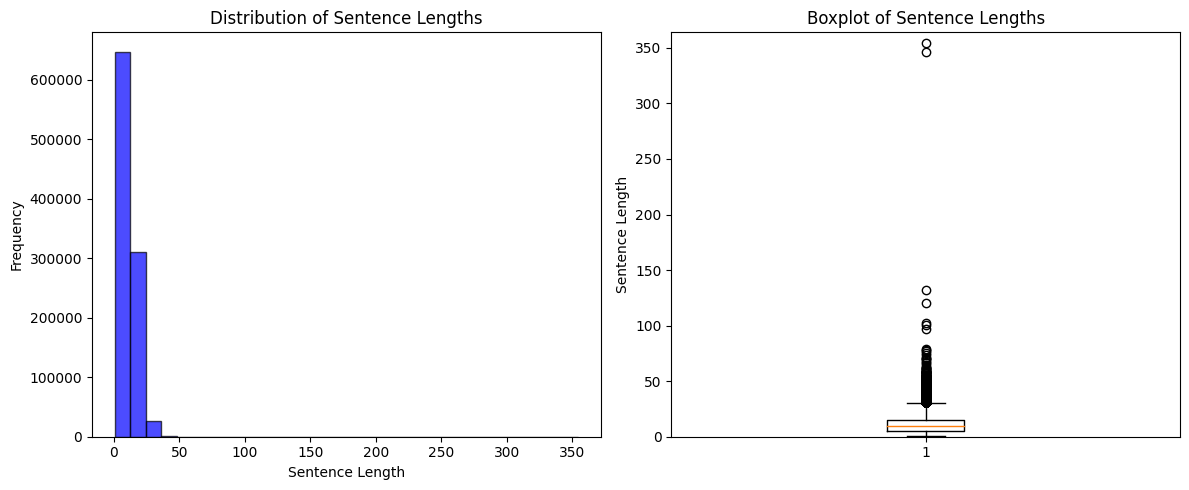

In [ ]:
import matplotlib.pyplot as plt

# Calculate sentence lengths
sentence_lengths = [len(sentence) for sentence in all_tokenized_sentences]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Plot the histogram
axs[0].hist(sentence_lengths, bins=30, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_title('Distribution of Sentence Lengths')
axs[0].set_xlabel('Sentence Length')
axs[0].set_ylabel('Frequency')
# Plot the boxplot with adjusted y-axis limits for zooming in
axs[1].boxplot(sentence_lengths)
axs[1].set_title('Boxplot of Sentence Lengths')
axs[1].set_ylabel('Sentence Length')

# Adjust y-axis limits for the boxplot
axs[1].set_ylim(0, max(sentence_lengths) + 10)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
from scipy.stats import skew
skewness = skew(sentence_lengths)
print("Skewness:", skewness)

Skewness: 1.118154026088167


In [ ]:
mean_sentence_length = sum(sentence_lengths) / len(sentence_lengths)

print("Mean Sentence Length:", mean_sentence_length)

Mean Sentence Length: 10.54761595413602


In [ ]:
model_w2v=Word2Vec(sg = 1,min_count=1,window=4,vector_size=200, alpha=0.01, hs=0,negative=10,workers=3,sample=0.001, shrink_windows=True)
model_w2v.build_vocab(all_tokenized_sentences)

model_w2v.train(all_tokenized_sentences, total_examples= len(all_tokenized_sentences), epochs=20)

(203809417, 207824740)

In [ ]:
# Get the list of words in the vocabulary
words = model_w2v.wv.key_to_index
print('Total number of unique words loaded in Model: ', len(model_w2v.wv.key_to_index))

# Create a corresponding list of the count for each word
word_ranks = []
for word in words:
    word_ranks.append(model_w2v.wv.get_vecattr(word, 'count'))

# Sort both lists by the word counts, descending (most frequent first)
word_ranks, words = map(list, zip(*sorted(zip(word_ranks, words), reverse=True)))

print('\nThe 30 most frequent words:\n')
print('    ---Rank---  ---Word---')

# For the 30 most frequent words
for i in range(30):
    # Print the rank with commas and pad it to 12 characters.
    print('{:>12,}     {:}'.format(word_ranks[i], words[i]))

print('\nThe 30 least frequent words:\n')
print('    ---Rank---   ---Word---')

# Go backward through the last 30 indices
for i in range(-1, -31, -1):
    # Print the count with commas and pad it to 12 characters.
    print('{:>12,}     {:}'.format(word_ranks[i], words[i]))



Total number of unique words loaded in Model:  119268

The 30 most frequent words:

    ---Rank---  ---Word---
     171,458     said
      55,627     year
      46,363     one
      43,167     people
      39,197     would
      35,856     time
      33,354     say
      32,900     state
      31,625     two
      31,406     also
      31,016     new
      30,188     cnn
      28,793     you
      25,807     day
      25,391     first
      25,262     s
      25,247     told
      23,908     like
      23,249     last
      22,588     government
      22,530     president
      22,421     could
      22,340     world
      21,464     police
      21,099     country
      20,215     according
      19,703     official
      19,228     get
      18,638     report
      17,770     home

The 30 least frequent words:

    ---Rank---   ---Word---
           1     00004
           1     0001
           1     00012
           1     0007
           1     0008
           1     000rpk
           

In [ ]:
word_vectors = model_w2v.wv
print('The vocabulary includes {} unique words.'.format(len(word_vectors.key_to_index)))
vector = model_w2v.wv['nice']
print('The length of a word vector according to the parameter "size": ',len(vector))
print('Numpy vector of the word "nice":\n',vector)

In [ ]:
model_w2v.save('/content/w2v_summ.model')


In [ ]:
model = Word2Vec.load("w2v_summ.model")
